In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import DataCleaning as dc
from sklearn.ensemble import RandomForestRegressor
import Tools

np.random.seed(123)
sns.set_style('darkgrid')
pd.set_option('display.max_colwidth', None)


In [2]:
apartments = pd.read_csv('data/apartments_train.csv')
apartments_test = pd.read_csv('data/apartments_test.csv')

print(f'Loaded {len(apartments)} apartments')
with open('data/apartments_meta.json') as f:
    apartments_meta = json.load(f)

Tools.describe_data(apartments, apartments_meta)

Loaded 23285 apartments


In [3]:
buildings = pd.read_csv('data/buildings_train.csv')
buildings_test = pd.read_csv("data/buildings_test.csv")

print(f'Loaded {len(buildings)} buildings')
with open('data/buildings_meta.json') as f:
    buildings_meta = json.load(f)
buildings.head()

Tools.describe_data(buildings, buildings_meta)


Loaded 6791 buildings


In [4]:
print(f'All apartments have an associated building: {apartments.building_id.isin(buildings.id).all()}')
data = pd.merge(apartments, buildings.set_index('id'), how='left', left_on='building_id', right_index=True)
data.head()

All apartments have an associated building: True


id  seller       price  area_total  area_kitchen  area_living  floor  \
0   0     3.0   7139520.0        59.2          12.5         31.0    2.0   
1   1     NaN  10500000.0        88.0          14.2         48.0   18.0   
2   2     3.0   9019650.0        78.5          22.5         40.8   12.0   
3   3     NaN  10500000.0        88.0          14.0         48.0   18.0   
4   4     NaN  13900000.0        78.0          17.0         35.0    7.0   

   rooms  layout  ceiling  ...  address  constructed  material  stories  \
0    2.0     NaN     2.65  ...   к2.5/2       2021.0       3.0      9.0   
1    3.0     1.0      NaN  ...     14к3       2010.0       3.0     25.0   
2    3.0     NaN     2.65  ...       38       2021.0       3.0     15.0   
3    3.0     NaN      NaN  ...     14к3       2010.0       3.0     25.0   
4    2.0     1.0     2.90  ...      1к3       2017.0       2.0     15.0   

   elevator_without  elevator_passenger  elevator_service  parking  \
0               0.0                 1.0               1.0      1.0   
1               0.0                 1.0               1.0      1.0   
2               0.0                 1.0               1.0      1.0   
3               0.0                 1.0               1.0      1.0   
4               0.0                 1.0               1.0      1.0   

   garbage_chute  heating  
0            NaN      NaN  
1            NaN      0.0  
2            NaN      NaN  
3            NaN      0.0  
4            0.0      0.0  

[5 rows x 34 columns]

## YA BOY HEHE

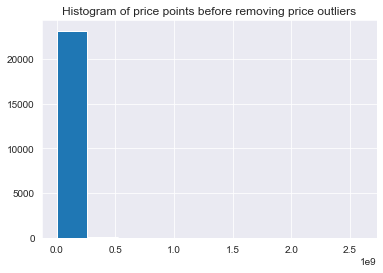

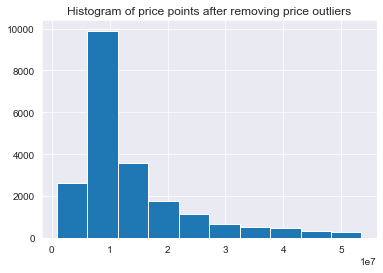

Skewness : 19.152175
Kurtosis : 716.628490


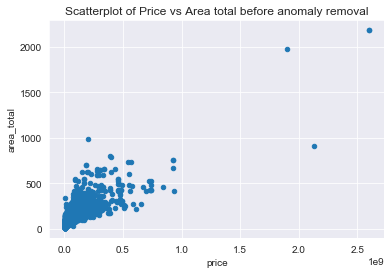

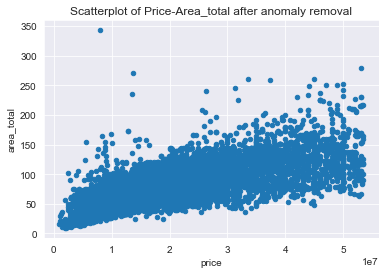

C:\Users\Kristian Tveiten\anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


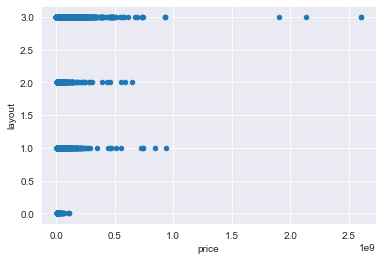

In [5]:
# Save old for comparison
apartments_old = apartments.copy()
data_old = data.copy()

 # Remove apartments with prices either
 # below or above the quarterly percentage
 # Data is now more normalized
dc.drop_outliers(data, "price")

Tools.describe_data(apartments, apartments_meta)

plt.hist(data_old["price"])
plt.title("Histogram of price points before removing price outliers")
plt.show()
plt.hist(data["price"])
plt.title("Histogram of price points after removing price outliers")
plt.show()

# Check Skewness and kurtosis
# Skewness - Absence of symmetry from the mean of the dataset
# Kurtosis - Is the distribution more or less peaked than the normal distribution? (Flat vs peaking)
print("Skewness : %f" % apartments['price'].skew()) # 1.56   Not bad
print("Kurtosis : %f" % apartments['price'].kurt()) # 1.98   Not bad

# Price vs total area plot
data_old.plot("price","area_total", "scatter")
plt.title("Scatterplot of Price vs Area total before anomaly removal")
plt.show()
data.plot("price","area_total", "scatter")
plt.title("Scatterplot of Price-Area_total after anomaly removal")
plt.show()

# Set all NaN values to "3"
apartments["layout"][np.isnan(apartments["layout"])] = 3
apartments.plot("price","layout","scatter")
plt.show()

In [6]:
# After setting all NaN values of layout to 3
# the relatively strong correlation to the seller can be seen
# indicating that it is unnecessary to keep this feature

Tools.correlation(data)

In [7]:
# Remove layout due to bad correlation and alot of NaN from DataFrame
data = data.drop(columns="layout")


In [8]:
# For the modelling part:
# Identify zero importance features in the training dataset based on
# feature importances from a gradient boosting model
# https://www.kaggle.com/nikkisharma536/house-prediction-dealing-with-missing-values

In [9]:
Tools.describe_data(apartments,apartments_meta)

In [10]:
"""
import LightGBM as lg

#LightGBM (Gradient Booster)
data = data.drop(columns=["street","address"])
df = data.copy()
Y = df["price"]
X = df.drop(columns="price")

zero_features, feature_importances = lg.identify_zero_importance_features(X, Y, iterations=2)
print('zero_features:', zero_features)
print(feature_importances)
"""

'\nimport LightGBM as lg\n\n#LightGBM (Gradient Booster)\ndata = data.drop(columns=["street","address"])\ndf = data.copy()\nY = df["price"]\nX = df.drop(columns="price")\n\nzero_features, feature_importances = lg.identify_zero_importance_features(X, Y, iterations=2)\nprint(\'zero_features:\', zero_features)\nprint(feature_importances)\n'

In [11]:
"""
feature_importances.describe()
pp = np.percentile(feature_importances['importance'], 20)

to_drop = feature_importances[feature_importances['importance'] <= pp]['feature']
print(to_drop)

data = data.drop(columns=to_drop)
"""

"\nfeature_importances.describe()\npp = np.percentile(feature_importances['importance'], 20)\n\nto_drop = feature_importances[feature_importances['importance'] <= pp]['feature']\nprint(to_drop)\n\ndata = data.drop(columns=to_drop)\n"

In [12]:
print(data)

          id  seller       price  area_total  area_kitchen  area_living  \
0          0     3.0   7139520.0        59.2          12.5         31.0   
1          1     NaN  10500000.0        88.0          14.2         48.0   
2          2     3.0   9019650.0        78.5          22.5         40.8   
3          3     NaN  10500000.0        88.0          14.0         48.0   
4          4     NaN  13900000.0        78.0          17.0         35.0   
...      ...     ...         ...         ...           ...          ...   
23280  23280     NaN  13300000.0        65.0          16.0         32.0   
23281  23281     3.0  15854300.0        56.9           9.6         36.5   
23282  23282     NaN  19800000.0        73.4          23.0         29.3   
23283  23283     0.0  29999000.0       100.8          20.0          NaN   
23284  23284     0.0  10950000.0        57.7           8.4          NaN   

       floor  rooms  ceiling  bathrooms_shared  ...  address  constructed  \
0        2.0    2.0   

In [13]:
#from autosklearn.experimental.askl2 import AutoSklearn2Classifier



In [14]:
plt.hist(np.log(data.price))
#plt.hist((data.price))
#plt.scatter(data.price, data.price)

(array([4.000e+00, 8.000e+00, 1.160e+02, 5.190e+02, 3.805e+03, 6.854e+03,
        4.313e+03, 2.678e+03, 1.696e+03, 1.232e+03]),
 array([13.71015004, 14.11865426, 14.52715848, 14.93566269, 15.34416691,
        15.75267113, 16.16117534, 16.56967956, 16.97818378, 17.38668799,
        17.79519221]),
 <a list of 10 Patch objects>)

In [15]:
print(data.district.unique())

[11.  2.  6. nan  5.  0.  7.  3.  4.  8.  1. 10.  9.]


In [16]:
import seaborn as sns
#data_test = data_test.drop(data_test[data.price>950000000].index)

# Rooms
print(data.isna().sum())
print(data.rooms.unique())
sns.boxplot(x='material',y='area_total', data=data)
#plt.scatter(data., data.price)

#plt.scatter(data.area_total, data.material)

id                       0
seller                7140
price                    0
area_total               0
area_kitchen          3708
area_living           2960
floor                    0
rooms                    0
ceiling               9830
bathrooms_shared      3244
bathrooms_private     3244
windows_court         7253
windows_street        7253
balconies             9209
loggias               9209
condition             9273
phones                  61
building_id              0
new                    253
latitude                 0
longitude                0
district               130
street                   0
address                  0
constructed            723
material              3687
stories                  0
elevator_without       340
elevator_passenger     340
elevator_service       340
parking               6434
garbage_chute         8331
heating               7519
dtype: int64
[2. 3. 1. 4. 5. 6.]


# Testing distance to universities

In [17]:
universities = [
    (55.67249540277297, 37.57367075739323),
    (55.848593408183014, 37.63366154242958),
    (55.6927502611028, 37.39749771164194),
    (55.85989907696161, 37.47471830960826),
    (55.71275216609847, 37.39960668456914),
    (55.668081662254856, 37.50617732696646),
    (55.73388744190375, 37.43235888837524),
    (55.67545847268359, 37.57650405765294),
    (55.76998506895896, 37.71307631112898),
    (55.636381586267106, 37.61111962636034),
    (55.78362014503218, 37.660868227044766),
    (55.69875568681356, 37.39433724232817),
    (55.82769889412336, 37.46133846385291),
    (55.8716119484216, 37.31466813820559),
    (55.77763401914524, 37.43414293198491)
]
uni = pd.DataFrame(universities)
uni.insert(0,'id', range(0+len(uni)))
uni = uni.rename(columns={"0": "lat", "1": "long"})
print(uni)


dist = None
for idx in data.id:
    dist = Tools.haversine([uni[0].values,uni[1].values], [data.loc[data.id == idx, "longitude"], data.loc[data.id == idx, "latitude"]],unit="m")
    data.loc[data.id == idx, "dist_metro"] = dist.min()


    id          0          1
0    0  55.672495  37.573671
1    1  55.848593  37.633662
2    2  55.692750  37.397498
3    3  55.859899  37.474718
4    4  55.712752  37.399607
5    5  55.668082  37.506177
6    6  55.733887  37.432359
7    7  55.675458  37.576504
8    8  55.769985  37.713076
9    9  55.636382  37.611120
10  10  55.783620  37.660868
11  11  55.698756  37.394337
12  12  55.827699  37.461338
13  13  55.871612  37.314668
14  14  55.777634  37.434143


KeyError: 0